In [ ]:
# !nvidia-smi

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
#
# # !ln -s ./drive/MyDrive/Data/MNISTDigitRecognize/ ../input
# !mkdir -p ../input
# !cp ./drive/MyDrive/Data/MNISTDigitRecognize/{data.npy,label.npy} ../input
# !ln -s ./drive/MyDrive/Data/MNISTDigitRecognize/save ./save
# !cp ./drive/MyDrive/Data/MNISTDigitRecognize/digit-recognizer.zip .
# !unzip digit-recognizer.zip > /dev/null
#
# !pip3 install -qU timm tqdm albumentations opencv-python torch-lr-finder


In [1]:
# libraries
import os
import time
import subprocess
import numpy as np
import pandas as pd
import ast
import cv2
import PIL.Image
import matplotlib.pyplot as plt
import timm
%matplotlib inline
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
# from warmup_scheduler import GradualWarmupScheduler
import albumentations
from albumentations.pytorch import ToTensorV2
import torch.cuda.amp as amp
# import segmentation_models_pytorch as smp
from tqdm import tqdm
from torchvision.io import read_image
import timm
from torch_lr_finder import LRFinder

scaler = amp.GradScaler()

import warnings
warnings.filterwarnings("ignore")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


/home/thaiminhpv/anaconda3/envs/thaiminhpv/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [95]:

# TRAIN_DIR = 'dataset/train/train/'
RANDOM_SEED = 42
BATCH_SIZE = 32
NUM_WORKERS = 4
NUM_CLASSES = 10
NUM_EPOCHS = 100
LR = 1e-2 # found by LRFinder


In [93]:

df = pd.read_csv('../input/train.csv')
data = df.drop(['label'], axis=1).to_numpy().reshape(-1, 28, 28)
label = df['label'].to_numpy()

# data = np.load('../input/data.npy')
# label = np.load('../input/label.npy')

data.shape, label.shape

((42000, 28, 28), (42000,))

In [97]:
# train, test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=RANDOM_SEED)

print("Train data shape:", X_train.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Train data shape: (33600, 28, 28) (33600,)
Test data shape: (8400, 28, 28) (8400,)


In [89]:
# create dataset
class MNist(Dataset):
    def __init__(self, data, label, transform=None):
        self.data = data
        self.label = label
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.label[idx]
        if self.transform:
            img = self.transform(image=img)['image']
            img = img.float()
        else:
            img = img.astype(np.float32)
            img = img[..., None] # (w, h) -> (w, h, 1)
            img = img.transpose((2, 0, 1))
            img = torch.from_numpy(img)

        img /= 255.0
        return img, label

In [90]:
transforms_train = albumentations.Compose([
    albumentations.RandomContrast(limit=0.2, p=0.5),
    ToTensorV2()
])
transforms_val = albumentations.Compose([
    ToTensorV2()
])

/home/thaiminhpv/anaconda3/envs/thaiminhpv/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [91]:

class EnetReg(nn.Module):
    def __init__(self, num_classes):
        super(EnetReg, self).__init__()
        self.enet = timm.create_model('tf_efficientnet_b0_ns', pretrained=True)
        # change input channels from RGB to grayscale
        self.enet.conv_stem.weight = nn.Parameter(self.enet.conv_stem.weight.mean(axis=1, keepdims=True))
        # retrain last layer
        self.enet.classifier = nn.Linear(self.enet.classifier.in_features, num_classes)
    def forward(self, x):
        x = self.enet(x)
        return x
_test_model = EnetReg(num_classes=10)
with torch.no_grad():
    print(_test_model(torch.rand(32, 1, 24, 24)).shape) # batch size must > 1 (batch norm)

torch.Size([32, 10])


/home/thaiminhpv/anaconda3/envs/thaiminhpv/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.00E-02


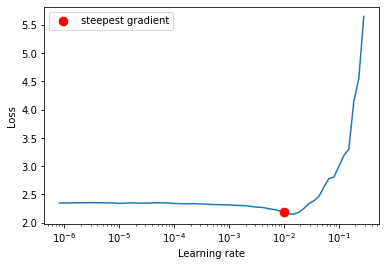

In [92]:
# find learning rate

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(_test_model.parameters(), lr=1e-7, weight_decay=1e-2)
find_lr_loader = DataLoader(
    MNist(data, label, transform=transforms_train),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

with amp.autocast():
    lr_finder = LRFinder(_test_model, optimizer, criterion, device=device)
    lr_finder.range_test(find_lr_loader, end_lr=100, num_iter=100)
    lr_finder.plot()
    lr_finder.reset()

In [87]:
def train_epoch(model, loader, optimizer):
    model.train()
    train_loss = []
    accs = []
    bar = tqdm(loader)
    for images, labels in bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_np = loss.item()
        train_loss.append(loss_np)

        acc = (logits.argmax(dim=1) == labels).float().mean().item()
        accs.append(acc)

        bar.set_description(f'loss: {loss_np:0.4f} | acc: {acc:0.4f}')
    return train_loss, accs

def val_epoch(model, loader):
    model.eval()
    val_loss = []
    accs = []
    bar = tqdm(loader)
    with torch.no_grad():
        for images, labels in bar:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            loss_np = loss.item()
            val_loss.append(loss_np)

            acc = (logits.argmax(dim=1) == labels).float().mean().item()
            accs.append(acc)

            bar.set_description(f'loss: {loss_np:0.4f} | acc: {acc:0.4f}')
    return val_loss, accs

In [88]:
# Custom Log
from torch.utils.tensorboard import SummaryWriter
TENSORBOARD_LOG_DIR = 'digit_recognizer'

# default `log_dir` is "runs" - we'll be more specific here
train_writer = SummaryWriter(f'runs/{TENSORBOARD_LOG_DIR}/train')
val_writer = SummaryWriter(f'runs/{TENSORBOARD_LOG_DIR}/val')

%load_ext tensorboard
# %reload_ext tensorboard
# %tensorboard --logdir runs/$TENSORBOARD_LOG_DIR

def log_and_save_metrics(epoch, metrics):
    # log metrics to tensorboard
    for k, v in metrics['train'].items():
        train_writer.add_scalar(k, v, epoch)
    for k, v in metrics['val'].items():
        val_writer.add_scalar(k, v, epoch)

    train_loss = metrics['train']['loss']
    val_loss = metrics['val']['loss']
    train_acc = metrics['train']['acc']
    val_acc = metrics['val']['acc']

    # log metrics to stdout
    print(f'Epoch: {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, Train Acc: {train_acc}, Val Acc: {val_acc}')

    # save metrics to disk
    np.save(f'save/loss_epoch_{epoch}.npy', np.array(train_loss))
    np.save(f'save/val_loss_epoch_{epoch}.npy', np.array(val_loss))
    np.save(f'save/acc_epoch_{epoch}.npy', np.array(train_acc))
    np.save(f'save/val_acc_epoch_{epoch}.npy', np.array(val_acc))


In [ ]:
def run(epoch_num, start_from_epoch=1):
    model = EnetReg(num_classes=10)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

    dataset_train = DataLoader(
        MNist(X_train, y_train, transform=transforms_train),
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS
    )

    dataset_val = DataLoader(
        MNist(X_test, y_test, transform=transforms_val),
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS
    )

    if start_from_epoch != 1:
        model.load_state_dict(torch.load(f'save/model_epoch_{start_from_epoch - 1}.pth'))
    for epoch in range(start_from_epoch, epoch_num):
        train_loss, train_acc = train_epoch(model, dataset_train, optimizer)
        val_loss, val_acc = val_epoch(model, dataset_val)

        scheduler.step(np.mean(val_loss), epoch)
        log_and_save_metrics(epoch, {
            'train': {
                'loss': np.mean(train_loss),
                'acc': np.mean(train_acc)
            },
            'val': {
                'loss': np.mean(val_loss),
                'acc': np.mean(val_acc)
            }
        })

        # save model
        torch.save(model.state_dict(), f'save/model_epoch_{epoch}.pth')

In [ ]:
dataset_visualize = DataLoader(
    MNist(X_train, y_train, transform=transforms_train),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)
# # model = EnetReg(num_classes=10)
# # model.to(device)
# images, labels = next(iter(dataset_train))
# # images, labels = images.to(device), labels.to(device)
# # logits = model(images)
# # loss = criterion(logits, labels)
images, labels = next(iter(dataset_visualize))

# display 32 images in a 4x8 grid to plt, and label them with their class name
plt.figure(figsize=(10, 10))

for i in range(BATCH_SIZE):
    plt.subplot(4, 8, i + 1)
    plt.imshow(images[i, 0].cpu().numpy(), cmap="gray")
    plt.title("{}".format(labels[i].item()))
    plt.axis("off")

In [ ]:
run(10, start_from_epoch=1)

In [ ]:
def inference():
    model = EnetReg(num_classes=10)
    model.load_state_dict(torch.load(f'save/model_epoch_299.pth'))
    model.to(device)

    df_test = pd.read_csv('../input/test.csv')
    X_test = df_test.drop(['label'], axis=1).to_numpy().reshape(-1, 28, 28)
    y_test = df_test['label'].to_numpy()

    dataset_inference = DataLoader(
        MNist(X_test, y_test, transform=transforms_val),
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, labels in tqdm(dataset_inference):
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = torch.argmax(logits, dim=1)
            predictions.append(preds.cpu().numpy())
    predictions = np.concatenate(predictions, axis=0)

    df_predictions = pd.read_csv('../input/sample_submission.csv')
    df_predictions['label'] = predictions
    df_predictions.to_csv('save/submission.csv', index=False)